# Pset4.1

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [26]:
def readData(images_file, labels_file):
    x = np.loadtxt(images_file, delimiter=',')
    y = np.loadtxt(labels_file, delimiter=',')
    return x, y

def nn_test(data, labels, params):
    h, output, loss = forward_prop(data, labels, params)
    accuracy = compute_accuracy(output, labels)
    return accuracy, loss

def compute_accuracy(output, labels):
    accuracy = (np.argmax(output,axis=1) == np.argmax(labels,axis=1)).sum() * 1. / labels.shape[0]
    return accuracy

def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels

def sigmoid(x):
    return 1./ (1 + np.exp(-x))

def softmax(x):
    """
    Compute softmax function for input. 
    Use tricks from previous assignment to avoid overflow
    """
    ### YOUR CODE HERE
    shifted = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted), axis=1, keepdims=True) + 0.00000001
    log_probs = shifted - np.log(Z)
    probs = np.exp(log_probs)
    ### END YOUR CODE
    return probs

def calc_loss(probs, labels):
    N = labels.shape[0]
    correct_logprobs = -np.log(np.sum(probs*labels, axis=1) + 0.00000001)
    data_loss = np.sum(correct_logprobs)/N
    return data_loss

def forward_prop(data, labels, params):
    """
    return hidded layer, output(softmax) layer and loss
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    reg = params['reg']

    ### YOUR CODE HERE
    N, D = data.shape
    X = data
    y = labels
    
    hidden_layer = sigmoid(np.dot(X, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    probs = softmax(scores)

    loss = calc_loss(probs, y)
    
    params['probs'] = probs
    params['hidden_layer'] = hidden_layer
    
    ### END YOUR CODE
    return hidden_layer, scores, loss

def backward_prop(data, labels, params):
    """
    return gradient of parameters
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    reg = params['reg']
    probs = params['probs']
    hidden_layer = params['hidden_layer']

    ### YOUR CODE HERE
    N, D = data.shape
    X = data
    y = labels
    
    dscores = probs-y
    dscores /= N

    gradW2 = np.dot(hidden_layer.T, dscores)
    gradb2 = np.sum(dscores, axis=0)
    dhidden = np.dot(dscores, W2.T)
    dz1 = dhidden*hidden_layer*(1-hidden_layer)
    gradW1 = np.dot(X.T, dz1)
    gradb1 = np.sum(dz1, axis=0)

    gradW2 += reg * 2.0 * W2
    gradW1 += reg * 2.0 * W1
    ### END YOUR CODE

    grad = {}
    grad['W1'] = gradW1
    grad['W2'] = gradW2
    grad['b1'] = gradb1
    grad['b2'] = gradb2

    return grad

def nn_train(trainData, trainLabels, devData, devLabels, reg, epochs=30, batch_size=1000, learning_rate=5):
    (m, n) = trainData.shape
    X = trainData
    y = trainLabels
    hidden_size = 300
    params = {'reg': reg}
    loss_history_train = []
    loss_history_val = []
    acc_history_train = []
    acc_history_val = []

    input_size = n
    output_size = 10 ## numbers 0-9
    num_train = m
    params['W1'] = np.random.standard_normal((input_size, hidden_size))
    params['W2'] = np.random.standard_normal((hidden_size, output_size))
    params['b1'] = np.zeros(hidden_size)
    params['b2'] = np.zeros(output_size)
    iterations_per_epoch = max(num_train // batch_size, 1)
    
    for it in range(epochs):
        for j in range(iterations_per_epoch):
            start = j*batch_size
            end = (j+1)*batch_size
            X_batch = X[start:end]
            y_batch = y[start:end]

            hidden_layer, scores, loss = forward_prop(X_batch, y_batch, params)
            grads = backward_prop(X_batch, y_batch, params)

            params['W1'] -= grads['W1'] * learning_rate
            params['b1'] -= grads['b1'] * learning_rate
            params['W2'] -= grads['W2'] * learning_rate
            params['b2'] -= grads['b2'] * learning_rate

        ## for graphs
        train_acc, train_loss = nn_test(trainData, trainLabels, params)
        val_acc, val_loss = nn_test(devData, devLabels, params)
        
        loss_history_train.append(train_loss)
        loss_history_val.append(val_loss)
        acc_history_train.append(train_acc)
        acc_history_val.append(val_acc)

    return {
        'loss_history_train': loss_history_train,
        'loss_history_val': loss_history_val,
        'acc_history_train': acc_history_train,
        'acc_history_val': acc_history_val,
        'params': params
    }

### Data Prep

In [3]:
np.random.seed(100)
trainData, trainLabels = readData('images_train.csv', 'labels_train.csv')
trainLabels = one_hot_labels(trainLabels)
p = np.random.permutation(60000)
trainData = trainData[p,:]
trainLabels = trainLabels[p,:]

devData = trainData[0:10000,:]
devLabels = trainLabels[0:10000,:]
trainData = trainData[10000:,:]
trainLabels = trainLabels[10000:,:]

mean = np.mean(trainData)
std = np.std(trainData)
trainData = (trainData - mean) / std
devData = (devData - mean) / std

testData, testLabels_orig = readData('images_test.csv', 'labels_test.csv')
testLabels = one_hot_labels(testLabels_orig)
testData = (testData - mean) / std

## Part a

In [27]:
no_reg = nn_train(trainData, trainLabels, devData, devLabels, 0)

In [28]:
loss_history_train_no_reg = no_reg['loss_history_train']
loss_history_val_no_reg = no_reg['loss_history_val']
acc_history_train_no_reg = no_reg['acc_history_train']
acc_history_val_no_reg = no_reg['acc_history_val']

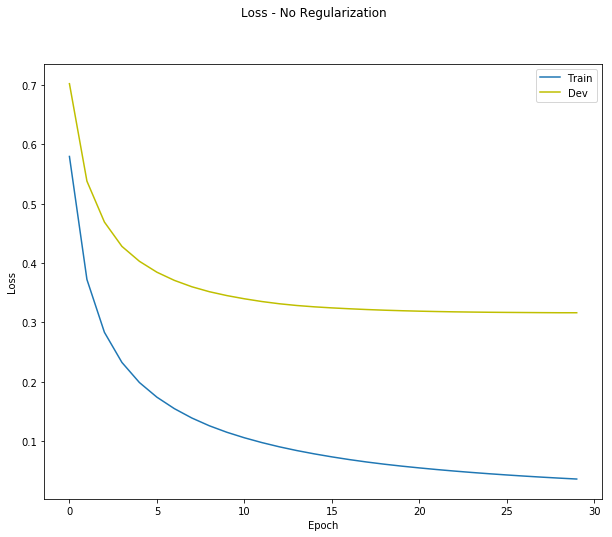

In [30]:
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(range(30), loss_history_train_no_reg, label='Train')
plt.plot(range(30), loss_history_val_no_reg, c='y', label='Dev')
plt.legend(loc='upper right')
plt.suptitle('Loss - No Regularization')
plt.show()

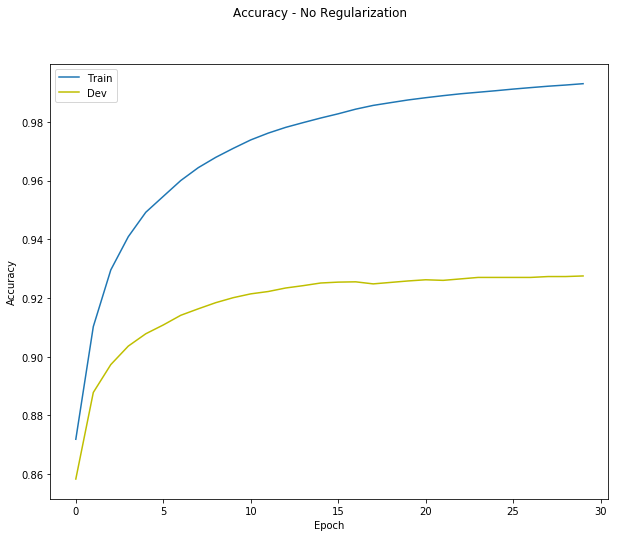

In [31]:
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(range(30), acc_history_train_no_reg, label='Train')
plt.plot(range(30), acc_history_val_no_reg, c='y', label='Dev')
plt.legend(loc='upper left')
plt.suptitle('Accuracy - No Regularization')
plt.show()

## Part b

In [33]:
reg = nn_train(trainData, trainLabels, devData, devLabels, 0.0001)

In [34]:
loss_history_train_reg = reg['loss_history_train']
loss_history_val_reg = reg['loss_history_val']
acc_history_train_reg = reg['acc_history_train']
acc_history_val_reg = reg['acc_history_val']

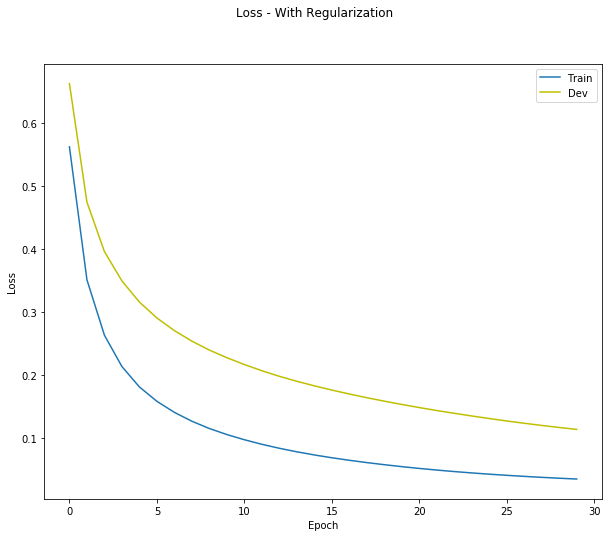

In [35]:
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(range(30), loss_history_train_reg, label='Train')
plt.plot(range(30), loss_history_val_reg, c='y', label='Dev')
plt.legend(loc='upper right')
plt.suptitle('Loss - With Regularization')
plt.show()

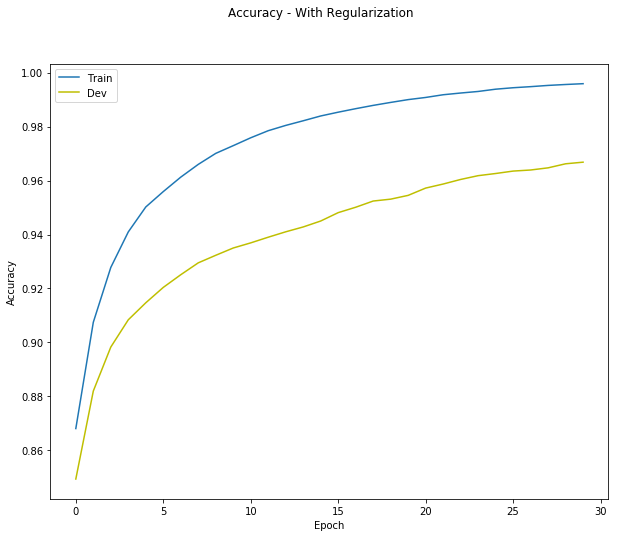

In [36]:
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(range(30), acc_history_train_reg, label='Train')
plt.plot(range(30), acc_history_val_reg, c='y', label='Dev')
plt.legend(loc='upper left')
plt.suptitle('Accuracy - With Regularization')
plt.show()

## Part c

In [41]:
accuracy = nn_test(testData, testLabels, no_reg['params'])[0]
print('Test accuracy non-reg: {}'.format(accuracy))

Test accuracy non-reg: 0.9339


In [42]:
accuracy = nn_test(testData, testLabels, reg['params'])[0]
print('Test accuracy reg: {}'.format(accuracy))

Test accuracy reg: 0.9662
